In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import re
import string
import nltk
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


import pickle

In [31]:
from importlib_metadata import version
print(version('pandas'))
print(version('numpy'))
print(version('flask'))
print(version('cython'))
print(version('jinja2'))
print(version('scikit-learn'))
print(version('tensorflow'))
print(version('nltk'))

1.4.2
1.21.5
1.1.2
0.29.28
2.11.3
1.1.1
2.9.1
3.7


In [2]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('words')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [3]:
df = pd.read_csv("train.csv")

In [4]:
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [5]:
df.shape   # print rows and columns in the dataframe

(20800, 5)

In [6]:
df.info()  # print info of dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [7]:
df.isnull().sum()     # checking for null values

id           0
title      558
author    1957
text        39
label        0
dtype: int64

# EDA

In [8]:
df['title'][0]

'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It'

In [9]:
df['text'][0]

'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It By Darrell Lucus on October 30, 2016 Subscribe Jason Chaffetz on the stump in American Fork, Utah ( image courtesy Michael Jolley, available under a Creative Commons-BY license) \nWith apologies to Keith Olbermann, there is no doubt who the Worst Person in The World is this week–FBI Director James Comey. But according to a House Democratic aide, it looks like we also know who the second-worst person is as well. It turns out that when Comey sent his now-infamous letter announcing that the FBI was looking into emails that may be related to Hillary Clinton’s email server, the ranking Democrats on the relevant committees didn’t hear about it from Comey. They found out via a tweet from one of the Republican committee chairmen. \nAs we now know, Comey notified the Republican chairmen and Democratic ranking members of the House Intelligence, Judiciary, and Oversight committees that his agency was reviewing emai

In [10]:
df['label'].value_counts()   # checking the distribution of sentiments

1    10413
0    10387
Name: label, dtype: int64

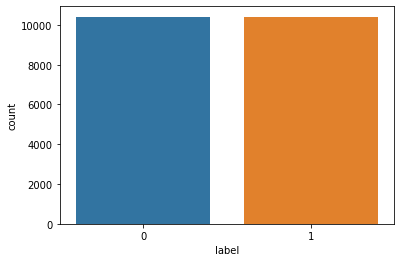

In [11]:
# checking the distribution of sentiments

sns.countplot(x = df['label'])

# Preprocess

In [12]:
_duplicates = df[df.duplicated(['text'], keep=False)]
non_duplicate_df = df.drop(_duplicates.index)

In [13]:
all_punctuations = string.punctuation + '‘’,:”][],'

nltk_words = set(nltk.corpus.words.words())

def preprocess(text):
    text = text.lower() # lowercase every document

    text = "".join(re.sub(r"http\S+", "", text, flags=re.IGNORECASE))   # remove URLs
    text = "".join(re.sub(r"[@[a-zA-Z]+:]*", "", text, flags=re.IGNORECASE)) # remove patterns like --> @warriorwoman:
    text = "".join(re.sub(r"[@[a-zA-Z]+_]*", "", text, flags=re.IGNORECASE)) # remove patterns like --> @warriorwoman_:
    text = "".join(re.sub(r"w/ @[a-zA_Z]*", "", text, flags=re.IGNORECASE)) # remove patterns like --> w/ @realDonaldTrump
    text = "".join(re.sub(r"[@[a-zA-Z\d]+:]*", "", text, flags=re.IGNORECASE)) # remove patterns like --> @warriorwoman91:
    text = "".join(re.sub(r"[@[a-zA-Z\d]+_]*", "", text, flags=re.IGNORECASE)) # remove patterns like --> @warriorwoman91_:
    text = "".join(re.sub(r"[0-9]*", "", text, flags = re.IGNORECASE))  # remove numbers
    text = "".join(re.sub('(\n|\r|\xa0)', "", text, flags = re.IGNORECASE))  # remove escape characters
    text = "".join(re.sub('(\[.\])', "", text, flags = re.IGNORECASE))  # remove patterns like [...]
    text = "".join(re.sub(r"[0-9]*", "", text, flags = re.IGNORECASE))  # remove numbers
    text = "".join(re.sub(r"( \w )*", "", text, flags = re.IGNORECASE)) # remove single characters
    
    
    no_punct = "".join([i for i in text if i not in all_punctuations])  # removing all punctuations
    
    words = no_punct.split()                   # splitting all the words
    no_stop_words = " ".join([i for i in words if i not in stopwords.words('english')])  # removing stop words
    
    lemmer = nltk.stem.WordNetLemmatizer()    # instanctiate the lemmatizer
    return " ".join([lemmer.lemmatize(word,'v') for word in no_stop_words.split()]) # lemmatize the words in the data

In [ ]:
non_duplicate_df['PreprocessText'] = non_duplicate_df['text'].apply(lambda x: preprocess(x))

In [ ]:
non_duplicate_df.to_csv('Preprocessed.csv', index = False)

# Text Cleaning

In [3]:
non_duplicate_df = pd.read_csv('Preprocessed.csv')

In [4]:
non_duplicate_df['PreprocessText'] = non_duplicate_df['PreprocessText'].astype(str)

In [5]:
# Get the count of words in each tweet and store in a new column

#non_duplicate_df['word_count'] = non_duplicate_df['PreprocessText'].apply(lambda x: sum([i.strip(string.punctuation).isalpha() for i in x.split()]))
non_duplicate_df['word_count'] = non_duplicate_df['PreprocessText'].apply(lambda x: len(x))

In [6]:
non_duplicate_df.head()

,id,title,author,text,label,PreprocessText,word_count
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,house dem didnt even see comeys letter jason c...,3247
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,ever get feel life circle roundabout rather he...,2705
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,truth might get fire october tension intellige...,5112
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,videos civilians kill single us airstrike iden...,2127
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,print iranian woman sentence six years prison ...,661


Text(0.5, 1.0, 'Distribution of number of tokens in tweets')

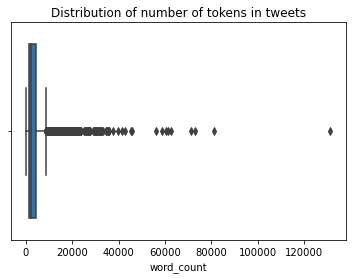

In [7]:
# checking for outliers 

sns.boxplot(x=non_duplicate_df['word_count'])
plt.title(('Distribution of number of tokens in tweets'))

<Figure size 720x720 with 0 Axes>

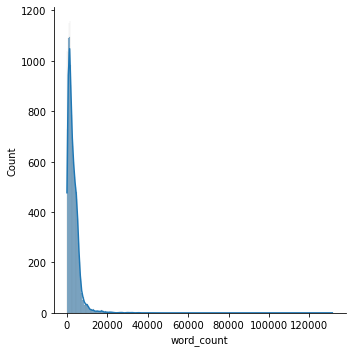

In [8]:
fig = plt.figure(figsize=(10,10))
sns.displot(x = non_duplicate_df['word_count'], kde=True)   # distributions of all the words

In [9]:
print(non_duplicate_df['word_count'].max())  # max words in doc
print(non_duplicate_df['word_count'].min())  # min words in doc

131406
1


In [10]:
non_duplicate_df = non_duplicate_df[non_duplicate_df['word_count']<20000]   # filter rows with words less than 20000, and store them

<Figure size 720x720 with 0 Axes>

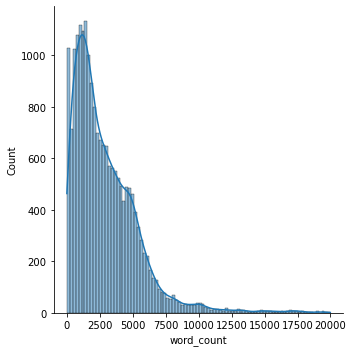

In [11]:
fig = plt.figure(figsize=(10,10))
sns.displot(x = non_duplicate_df['word_count'], kde=True)   # distributions of all the words

In [12]:
count, division = np.histogram(non_duplicate_df['word_count'])
count, division

(array([9079, 5674, 3603, 1014,  355,  176,   89,   58,   61,   26],
       dtype=int64),
 array([1.00000e+00, 1.99970e+03, 3.99840e+03, 5.99710e+03, 7.99580e+03,
        9.99450e+03, 1.19932e+04, 1.39919e+04, 1.59906e+04, 1.79893e+04,
        1.99880e+04]))

# Random Forest Classifier

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

In [14]:
sentence_list = non_duplicate_df['PreprocessText'].tolist()

In [15]:
tfidf = TfidfVectorizer(max_features = 3000)
sentence_vectors = tfidf.fit_transform(sentence_list).toarray()

In [16]:
sentence_vectors

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [17]:
X_train, X_test, y_train, y_test = train_test_split(sentence_vectors, np.asarray(non_duplicate_df['label']), test_size=0.2, random_state=42)

In [18]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [19]:
predictions = rf.predict(X_test)

In [21]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      2042
           1       0.94      0.94      0.94      1985

    accuracy                           0.94      4027
   macro avg       0.94      0.94      0.94      4027
weighted avg       0.94      0.94      0.94      4027



<Figure size 720x720 with 0 Axes>

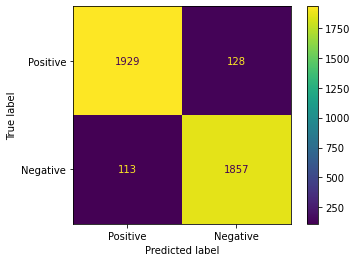

In [22]:
# plot confusion matrix
fig = plt.figure(figsize=(10,10))

confusion_mat = ConfusionMatrixDisplay(confusion_matrix(predictions, y_test), display_labels = ['Positive', 'Negative'])

confusion_mat.plot()

In [29]:
test_word ='Donald J. Trump is scheduled to make a highly anticipated visit to an   church in Detroit on Saturday, the first such visit of his campaign. There, he will participate in a    session conducted by Bishop Wayne T. Jackson of the church, Great Faith Ministries International. Given the importance of the visit, the Trump team went so far as to script Mr. Trumpâ€™s answers to Bishop Jacksonâ€™s questions, which were submitted in advance. After this article was published on Thursday night, a campaign official said that Mr. Trump would also speak to the churchâ€™s congregation and then tour some neighborhoods with Ben Carson, a former presidential candidate and Detroit native. Below are excerpts from a draft of the script that was obtained by The New York Times. _____ Mr. Trump there is racial divide in our country and it is evident that the tension is boiling over. Case and point Reverend Pinckney in South Carolina was gunned down when a white young man came into their Bible Study and slaughtered the Reverend and eight other individuals because he wanted to start a race war. What would your administration do to bring down the racial tension that is in our Country? In the Bible Jesus said that a house divided cannot stand. Our best hope for erasing racial tensions in America is to work toward a   society. In business, we hire, retain and award based on merit. In society, however, we have divisions that can only be eliminated if we have equal opportunity and then equal access to programs and institutions that will lift all people in the country. We have to reform our tax system so that we can spur economic growth for the long haul. We have to have stronger enforcement of immigration laws. We have to renegotiate our trade deals so that we can bring advantage back to the American workforce. But perhaps most important is that we must provide equal opportunity for a quality education for all Americans. The higher the educational attainment, the greater the likelihood one can climb the economic ladder. We must bring school choice programs to our cities and we must get rid of Common Core. We must make sure that access, affordability and accountability are brought into our higher education system. Without a focus on educational outcomes for every American, we will perpetuate the permanent underclass that progressive policies have sustained. Republicans like me need to have the courage to speak the truth about where we are and what has to be done. We have to have the courage to go into communities and work with everyone there to make sure that our schools are good and that our children have access to the whatever educational situation they may need. This is not something one person can do, but it is something that we can do together. _____ Mr. Trump there is a perception that your administration is racist. With many of the African American voters their belief is that the Republican Party as a whole does not cater to African American needs. In 2008 and 2012 we had two Republican Candidates John McCain and Mitt Romney and neither one of them came to Detroit, or any urban area that I can remember to even address the concerns of our community. First I would like to commend you for coming to our community as a Republican Candidate. Second I need to know how would you change that perception in our community? The proof, as they say, will be in the pudding. Coming into a community is meaningless unless we can offer an alternative to the horrible progressive agenda that has perpetuated a permanent underclass in America. We need to be true to our word and offer all Americans more opportunities so that each and every one of them can reach their full potential. This means economic policies that will bring jobs back to America and will raise wages for all. This means working hard to provide as many educational options as possible to our parents and children. This means cleaning up drugs and making our neighborhoods and communities safer. We need to get people off welfare and back to work. We need to make sure that anyone who qualifies can go into a bank, get a loan and then start a business. We need to reduce regulations and expand options for people who want to be independent of government. We need to make sure that people can worship how they want and where they want without worrying that some federal agency is going to threaten the religious liberties. Republicans have better options. We just need to have the courage to present them with conviction. _____ Mr. Trump what is your vision for America? And specifically Black America? If you repeal Obama care what is your plan to provide health care and medicine to those who canâ€™t afford it, yet need it the most? As President, I must serve all Americans without regard to race, ethnicity or any other qualification. I must approach my task with the utmost wisdom and make sure that all Americans have opportunities to achieve to their potential. If we are to Make America Great Again, we must reduce, rather than highlight, issues of race in this country. I want to make race disappear as a factor in government and governance. Every individual, regardless of race or ethnicity, must have access to the full array of opportunities in America. My vision for America is that every citizen and legal resident of this nation will be able to stand side by side and be proud of the fact that they live in the greatest nation on earth. As for the Affordable Care Act, I will work to repeal the act and replace it with market driven solutions that will offer more access to healthcare at more affordable prices. Every American should be able to purchase health insurance across state lines, have health savings account that belong to them, have price transparency so they can shop for the best services at the best prices and know that they will not have to compete with those who are clogging the system simply because they are in this country illegally. We want to block grant Medicaid so that states can provide services closer to the people. We want to make sure that every American has great economic opportunity so that they can seek out their own health insurance and still be able to afford it. This approach will serve all Americans and will ensure that more Americans are covered by better insurance and healthcare options. _____ Mr. Trump I am a registered Democrat but I am an undecided voter in this election for 2016. It is not only myself but there has been a lot of Pastors and African Americans who have not made up their minds concerning who they are going to cast their vote for. The latest polls indicate that you have 1 percent of the African American vote. What can you say to undecided voters such as myself and others in the African American Community that will win our vote on November 8, 2016? And beyond winning, why is the African American vote important to you? All votes are important to me and my campaign. Your vote, your neighborâ€™s vote, the vote of every American is critical and I must do all I can to make sure you know that if you vote for me, you are voting for a stronger, more vibrant America. My policies offer you a clear choice. You can continue down the road of progressivism that has created a permanent underclass in this country that, unfortunately, includes far too many people of color. If you want a better America, you must break from the historical hold that Democrats have had on people of color and move to options that allow you to achieve your potential. This is all about opportunity  â€”   not   outcomes and promises of things to come that never materialize. The progressives have worked tirelessly to bring all Americans down to one level rather than allowing as many as possible to rise as high as possible. Education, jobs, religious liberty and protection of civil rights are the promises that I will keep, not just utter to gain favor. If you are interested in a greater America with more opportunity, liberty and prosperity, you must take a chance and walk over to my side. If you want a strong partner in this journey, you will vote for me. I will never let you down. By the way, my support is now up to 8% and climbing.'                       # input sequence
tw = tfidf.transform([test_word])  # vectorize input  sequence
prediction = rf.predict(tw).item()           # make predictions
print(prediction)                            # print prediction

0


In [23]:
with open('vectorizer.pkl', 'wb') as vect:
    pickle.dump(tfidf, vect)

In [26]:
with open('rfmodel.pkl', 'wb') as m:
    pickle.dump(rf, m)